In [1]:
import numpy as np
import pandas as pd

import random
random.seed(28)
np.random.seed(28)

import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
import os
import copy
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
from collections import defaultdict
import lightgbm as lgb
import xgboost as xgb
import time
from collections import Counter
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
#import eli5
import shap
from IPython.display import HTML
import json

import matplotlib.pyplot as plt
%matplotlib inline
import os
import time
import datetime
import gc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
pd.set_option('max_rows', 500)
import re

import os

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:20,.2f}'.format)
pd.set_option('display.max_colwidth', -1)

np.random.seed(2206)

# Read the data

In [2]:
train = pd.read_csv("data/training_v2.csv")
samplesubmission = pd.read_csv("data/samplesubmission.csv")
test = pd.read_csv("data/unlabeled.csv")
dictionary = pd.read_csv("data/WiDS Datathon 2020 Dictionary.csv")
solution_template = pd.read_csv("data/solution_template.csv")

print('train ' , train.shape)
print('test ' , test.shape)
print('samplesubmission ' , samplesubmission.shape)
print('solution_template ' , solution_template.shape)
print('dictionary ' , dictionary.shape)

train  (91713, 186)
test  (39308, 186)
samplesubmission  (3, 2)
solution_template  (39308, 2)
dictionary  (188, 6)


In [3]:
dico = pd.DataFrame(dictionary.T.head(6))
dico.columns=list(dico.loc[dico.index == 'Variable Name'].unstack())
dico = dico.loc[dico.index != 'Variable Name']
dico.columns
train_stat = pd.DataFrame(train.describe())
train_stat2 = pd.concat([dico,train_stat],axis=0)
train_stat2.head(20)

,age,aids,albumin_apache,apache_2_bodysystem,apache_2_diagnosis,apache_3j_bodysystem,apache_3j_diagnosis,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,apache_post_operative,arf_apache,bilirubin_apache,bmi,bun_apache,cirrhosis,creatinine_apache,d1_albumin_max,d1_albumin_min,d1_arterial_pco2_max,d1_arterial_pco2_min,d1_arterial_ph_max,d1_arterial_ph_min,d1_arterial_po2_max,d1_arterial_po2_min,d1_bilirubin_max,d1_bilirubin_min,d1_bun_max,d1_bun_min,d1_calcium_max,d1_calcium_min,d1_creatinine_max,d1_creatinine_min,d1_diasbp_invasive_max,d1_diasbp_invasive_min,d1_diasbp_max,d1_diasbp_min,d1_diasbp_noninvasive_max,d1_diasbp_noninvasive_min,d1_glucose_max,d1_glucose_min,d1_hco3_max,d1_hco3_min,d1_heartrate_max,d1_heartrate_min,d1_hemaglobin_max,d1_hemaglobin_min,d1_hematocrit_max,d1_hematocrit_min,d1_inr_max,d1_inr_min,d1_lactate_max,d1_lactate_min,d1_mbp_invasive_max,d1_mbp_invasive_min,d1_mbp_max,d1_mbp_min,d1_mbp_noninvasive_max,d1_mbp_noninvasive_min,d1_pao2fio2ratio_max,d1_pao2fio2ratio_min,d1_platelets_max,d1_platelets_min,d1_potassium_max,d1_potassium_min,d1_resprate_max,d1_resprate_min,d1_sodium_max,d1_sodium_min,d1_spo2_max,d1_spo2_min,d1_sysbp_invasive_max,d1_sysbp_invasive_min,d1_sysbp_max,d1_sysbp_min,d1_sysbp_noninvasive_max,d1_sysbp_noninvasive_min,d1_temp_max,d1_temp_min,d1_wbc_max,d1_wbc_min,diabetes_mellitus,elective_surgery,encounter_id,ethnicity,fio2_apache,gcs_eyes_apache,gcs_motor_apache,gcs_unable_apache,gcs_verbal_apache,gender,glucose_apache,h1_albumin_max,h1_albumin_min,h1_arterial_pco2_max,h1_arterial_pco2_min,h1_arterial_ph_max,h1_arterial_ph_min,h1_arterial_po2_max,h1_arterial_po2_min,h1_bilirubin_max,h1_bilirubin_min,h1_bun_max,h1_bun_min,h1_calcium_max,h1_calcium_min,h1_creatinine_max,h1_creatinine_min,h1_diasbp_invasive_max,h1_diasbp_invasive_min,h1_diasbp_max,h1_diasbp_min,h1_diasbp_noninvasive_max,h1_diasbp_noninvasive_min,h1_glucose_max,h1_glucose_min,h1_hco3_max,h1_hco3_min,h1_heartrate_max,h1_heartrate_min,h1_hemaglobin_max,h1_hemaglobin_min,h1_hematocrit_max,h1_hematocrit_min,h1_inr_max,h1_inr_min,h1_lactate_max,h1_lactate_min,h1_mbp_invasive_max,h1_mbp_invasive_min,h1_mbp_max,h1_mbp_min,h1_mbp_noninvasive_max,h1_mbp_noninvasive_min,h1_pao2fio2ratio_max,h1_pao2fio2ratio_min,h1_platelets_max,h1_platelets_min,h1_potassium_max,h1_potassium_min,h1_resprate_max,h1_resprate_min,h1_sodium_max,h1_sodium_min,h1_spo2_max,h1_spo2_min,h1_sysbp_invasive_max,h1_sysbp_invasive_min,h1_sysbp_max,h1_sysbp_min,h1_sysbp_noninvasive_max,h1_sysbp_noninvasive_min,h1_temp_max,h1_temp_min,h1_wbc_max,h1_wbc_min,heart_rate_apache,height,hematocrit_apache,hepatic_failure,hospital_admit_source,hospital_death,hospital_id,icu_admit_source,icu_admit_type,icu_id,icu_stay_type,icu_type,immunosuppression,intubated_apache,leukemia,lymphoma,map_apache,paco2_apache,paco2_for_ph_apache,pao2_apache,patient_id,ph_apache,pre_icu_los_days,pred,readmission_status,resprate_apache,sodium_apache,solid_tumor_with_metastasis,temp_apache,urineoutput_apache,ventilated_apache,wbc_apache,weight
Category,demographic,APACHE comorbidity,APACHE covariate,APACHE grouping,APACHE covariate,APACHE grouping,APACHE covariate,APACHE prediction,APACHE prediction,APACHE covariate,APACHE covariate,APACHE covariate,demographic,APACHE covariate,APACHE comorbidity,APACHE covariate,labs,labs,labs blood gas,labs blood gas,labs blood gas,labs blood gas,labs blood gas,labs blood gas,labs,labs,labs,labs,labs,labs,labs,labs,vitals,vitals,vitals,vitals,vitals,vitals,labs,labs,labs,labs,vitals,vitals,labs,labs,labs,labs,labs,labs,labs,labs,vitals,vitals,vitals,vitals,vitals,vitals,labs blood gas,labs blood gas,labs,labs,labs,labs,vitals,vitals,labs,labs,vitals,vitals,vitals,vitals,vitals,vitals,vitals,vitals,vitals,vitals,labs,labs,APACHE comorbidity,demographic,identifier,demographic,APACHE covariate,APACHE covariate,APACHE covariate,APACHE covariate,APACHE covariate,demographic,APACHE covariate,labs,labs,labs blood gas,labs blood gas,labs blood gas,labs blood gas

# OverView of the dataset

In [4]:
train_stat2.T.head(200)

,Category,Unit of Measure,Data Type,Description,Example,count,mean,std,min,25%,50%,75%,max
age,demographic,Years,numeric,The age of the patient on unit admission,None,"87,485.00",62.31,16.78,16.00,52.00,65.00,75.00,89.00
aids,APACHE comorbidity,None,binary,Whether the patient has a definitive diagnosis of acquired immune deficiency syndrome (AIDS) (not HIV positive alone),1,"90,998.00",0.00,0.03,0.00,0.00,0.00,0.00,1.00
albumin_apache,APACHE covariate,g/L,numeric,The albumin concentration measured during the first 24 hours which results in the highest APACHE III score,30,"37,334.00",2.90,0.68,1.20,2.40,2.90,3.40,4.60
apache_2_bodysystem,APACHE grouping,None,string,Admission diagnosis group for APACHE II,Respiratory,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apache_2_diagnosis,APACHE covariate,None,string,The APACHE II diagnosis for the ICU admission,308,"90,051.00",185.40,86.05,101.00,113.00,122.00,301.00,308.00
apache_3j_bodysystem,APACHE grouping,None,string,Admission diagnosis group for APACHE III,Cardiovascular,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
apache_3j_diagnosis,APACHE covariate,None,string,The APACHE III-J sub-diagnosis code which best describes the reason for the ICU admission,1405,"90,612.00",558.22,463.27,0.01,203.01,409.02,703.03,"2,201.05"
apache_4a_hospital_death_prob,APACHE prediction,None,numeric,"The APACHE IVa probabilistic prediction of in-hospital mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis.",0.31,"83,766.00",0.09,0.25,-1.00,0.02,0.05,0.13,0.99
apache_4a_icu_death_prob,APACHE prediction,None,numeric,"The APACHE IVa probabilistic prediction of in ICU mortality for the patient which utilizes the APACHE III score and other covariates, including diagnosis",0.24,"83,766.00",0.04,0.22,-1.00,0.01,0.02,0.06,0.97
apache_post_operative,APACHE covariate,None,binary,"The APACHE operative status; 1 for post-operative, 0 for non-operative",1,"91,713.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00


In [5]:
# function to evaluate the score of our model
def eval_auc(pred,real):
    false_positive_rate, recall, thresholds = roc_curve(real, pred)
    roc_auc = auc(false_positive_rate, recall)
    return roc_auc    

In [6]:
# a wrapper class  that we can have the same ouput whatever the model we choose
class Base_Model(object):
    
    def __init__(self, train_df, test_df, features, categoricals=[], n_splits=5, verbose=True,ps={}):
        self.train_df = train_df
        self.test_df = test_df
        self.features = features
        self.n_splits = n_splits
        self.categoricals = categoricals
        self.target = 'hospital_death'
        self.cv = self.get_cv()
        self.verbose = verbose
#         self.params = self.get_params()
        self.params = self.set_params(ps)
        self.y_pred, self.score, self.model , self.oof_pred = self.fit()
        
    def train_model(self, train_set, val_set):
        raise NotImplementedError
        
    def get_cv(self):
        cv = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)
        return cv.split(self.train_df, self.train_df[self.target])
    
    def get_params(self):
        raise NotImplementedError
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        raise NotImplementedError
        
    def convert_x(self, x):
        return x
        
    def fit(self):
        oof_pred = np.zeros((len(self.train_df), ))
        y_pred = np.zeros((len(self.test_df), ))
        for fold, (train_idx, val_idx) in enumerate(self.cv):
            x_train, x_val = self.train_df[self.features].iloc[train_idx], self.train_df[self.features].iloc[val_idx]
            y_train, y_val = self.train_df[self.target][train_idx], self.train_df[self.target][val_idx]
            train_set, val_set = self.convert_dataset(x_train, y_train, x_val, y_val)
            model = self.train_model(train_set, val_set)
            conv_x_val = self.convert_x(x_val)
            oof_pred[val_idx] = model.predict(conv_x_val).reshape(oof_pred[val_idx].shape)
            x_test = self.convert_x(self.test_df[self.features])
            y_pred += model.predict(x_test).reshape(y_pred.shape) / self.n_splits

            print('Partial score of fold {} is: {}'.format(fold,eval_auc(oof_pred[val_idx],y_val) ))
        #print(oof_pred, self.train_df[self.target].values)
        loss_score = eval_auc(oof_pred,self.train_df[self.target].values) 
        if self.verbose:
            print('Our oof AUC score is: ', loss_score)
        return y_pred, loss_score, model , oof_pred

In [7]:
#we choose to try a LightGbM using the Base_Model class
class Lgb_Model(Base_Model):
    
    def train_model(self, train_set, val_set):
        verbosity = 100 if self.verbose else 0
        return lgb.train(self.params, train_set, valid_sets=[train_set, val_set], verbose_eval=verbosity)
        
    def convert_dataset(self, x_train, y_train, x_val, y_val):
        train_set = lgb.Dataset(x_train, y_train, categorical_feature=self.categoricals)
        val_set   = lgb.Dataset(x_val,    y_val,  categorical_feature=self.categoricals)
        return train_set, val_set
        
    def get_params(self):
        params = {'n_estimators':5000,
                    'boosting_type': 'gbdt',
                    'objective': 'binary',
                    'metric': 'auc',
                    'subsample': 0.75,
                    'subsample_freq': 1,
                    'learning_rate': 0.1,
                    'feature_fraction': 0.9,
                    'max_depth': 15,
                    'lambda_l1': 1,  
                    'lambda_l2': 1,
                    'early_stopping_rounds': 100,
                    #'is_unbalance' : True ,
                    'scale_pos_weight' : 3
                  
                    }
        return params
    def set_params(self,ps={}):
        params = self.get_params()
        if 'subsample_freq' in ps:
            params['subsample_freq']=int(ps['subsample_freq'])
            params['learning_rate']=ps['learning_rate']
            params['feature_fraction']=ps['feature_fraction']
            params['lambda_l1']=ps['lambda_l1']
            params['lambda_l2']=ps['lambda_l2']
            params['scale_pos_weight']=ps['scale_pos_weight']
            params['max_depth']=int(ps['max_depth'])
        
        return params  

In [8]:
#we are going to drop these columns because we dont want our ML model to be bias toward these consideration
#(we also remove the target and the ids.)
to_drop = ['gender','ethnicity' ,'encounter_id', 'patient_id',  'hospital_death']

# this is a list of features that look like to be categorical
categoricals_features = ['hospital_id','ethnicity','gender','hospital_admit_source','icu_admit_source','icu_stay_type','icu_type','apache_3j_bodysystem','apache_2_bodysystem']
categoricals_features = [col for col in categoricals_features if col not in to_drop]

# this is the list of all input feature we would like our model to use 
features = [col for col in train.columns if col not in to_drop ]
print('numerber of features ' , len(features))
print('shape of train / test ', train.shape , test.shape)

numerber of features  181
shape of train / test  (91713, 186) (39308, 186)


categorical feature need to be transform to numeric for mathematical purpose.
different technics of categorical encoding exists here we will rely on our model API to deal with categorical
still we need to encode each categorical value to an id , for this purpose we use LabelEncoder


In [9]:
# categorical feature need to be transform to numeric for mathematical purpose.
# different technics of categorical encoding exists here we will rely on our model API to deal with categorical
# still we need to encode each categorical value to an id , for this purpose we use LabelEncoder

print('Transform all String features to category.\n')
for usecol in categoricals_features:
    train[usecol] = train[usecol].astype('str')
    test[usecol] = test[usecol].astype('str')
    
    #Fit LabelEncoder
    le = LabelEncoder().fit(
            np.unique(train[usecol].unique().tolist()+
                      test[usecol].unique().tolist()))

    #At the end 0 will be used for dropped values
    train[usecol] = le.transform(train[usecol])+1
    test[usecol]  = le.transform(test[usecol])+1
    
    train[usecol] = train[usecol].replace(np.nan, 0).astype('int').astype('category')
    test[usecol]  = test[usecol].replace(np.nan, 0).astype('int').astype('category')

Transform all String features to category.



# Modele

In [10]:
# percentage of death , hopefully it s a bit unbalanced
train['hospital_death'].sum()/train['hospital_death'].count()

0.08630183289173836

# Hyper parameter tuning

In [11]:
def LGB_Beyes(subsample_freq,
                    learning_rate,
                    feature_fraction,
                    max_depth,
                    lambda_l1,
                    lambda_l2,
                    scale_pos_weight):
    params={}
    params['subsample_freq']=subsample_freq
    params['learning_rate']=learning_rate
    params['feature_fraction']=feature_fraction
    params['lambda_l1']=lambda_l1
    params['lambda_l2']=lambda_l2
    params['max_depth']=max_depth
    params['scale_pos_weight']=scale_pos_weight
    
    lgb_model= Lgb_Model(train, test, features, categoricals=categoricals_features,ps=params)
    print('auc: ',lgb_model.score)
    return lgb_model.score

bounds_LGB = {
    'subsample_freq': (1, 10),
    'learning_rate': (0.005, 0.02),
    'feature_fraction': (0.5, 1),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 5),
    'max_depth': (13, 17),
    'scale_pos_weight': (1, 10),
}

# ACTIVATE it if you want to search for better parameter
if 0 : 
    LGB_BO = BayesianOptimization(LGB_Beyes, bounds_LGB, random_state=1029)
    import warnings
    init_points = 16
    n_iter = 16
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')    
        LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

In [12]:
params = {'feature_fraction': 0.9,
 'lambda_l1': 1,
 'lambda_l2': 1,
 'learning_rate': 0.1,
 'max_depth': 13,
 'subsample_freq': 1,
 'scale_pos_weight':1}

In [13]:
lgb_model = Lgb_Model(train,test, features, categoricals=categoricals_features, ps=params)

Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.957687	valid_1's auc: 0.902798
[200]	training's auc: 0.98124	valid_1's auc: 0.902624
[300]	training's auc: 0.992194	valid_1's auc: 0.90336
Early stopping, best iteration is:
[294]	training's auc: 0.991747	valid_1's auc: 0.903492
Partial score of fold 0 is: 0.903491829205596
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.957394	valid_1's auc: 0.899268
[200]	training's auc: 0.982102	valid_1's auc: 0.899141
Early stopping, best iteration is:
[120]	training's auc: 0.964059	valid_1's auc: 0.899554
Partial score of fold 1 is: 0.8995544847778529
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.958833	valid_1's auc: 0.897969
[200]	training's auc: 0.98229	valid_1's auc: 0.89825
Early stopping, best iteration is:
[156]	training's auc: 0.974502	valid_1's auc: 0.899157
Partial score of fold 2 is: 0.8991573656255231
Training until validati

Feature Importance from the lightgbm model (gain)

In [14]:
imp_df = pd.DataFrame()
imp_df['feature'] = features
imp_df['gain']  = lgb_model.model.feature_importance(importance_type='gain')
imp_df['split'] = lgb_model.model.feature_importance(importance_type='split')

In [15]:
def plot_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(18, 44))
    data_imp = importances_.sort_values('mean_gain', ascending=False)
    sns.barplot(x='gain', y='feature', data=data_imp[:300])
    plt.tight_layout()
    plt.savefig('importances.png')
    plt.show()

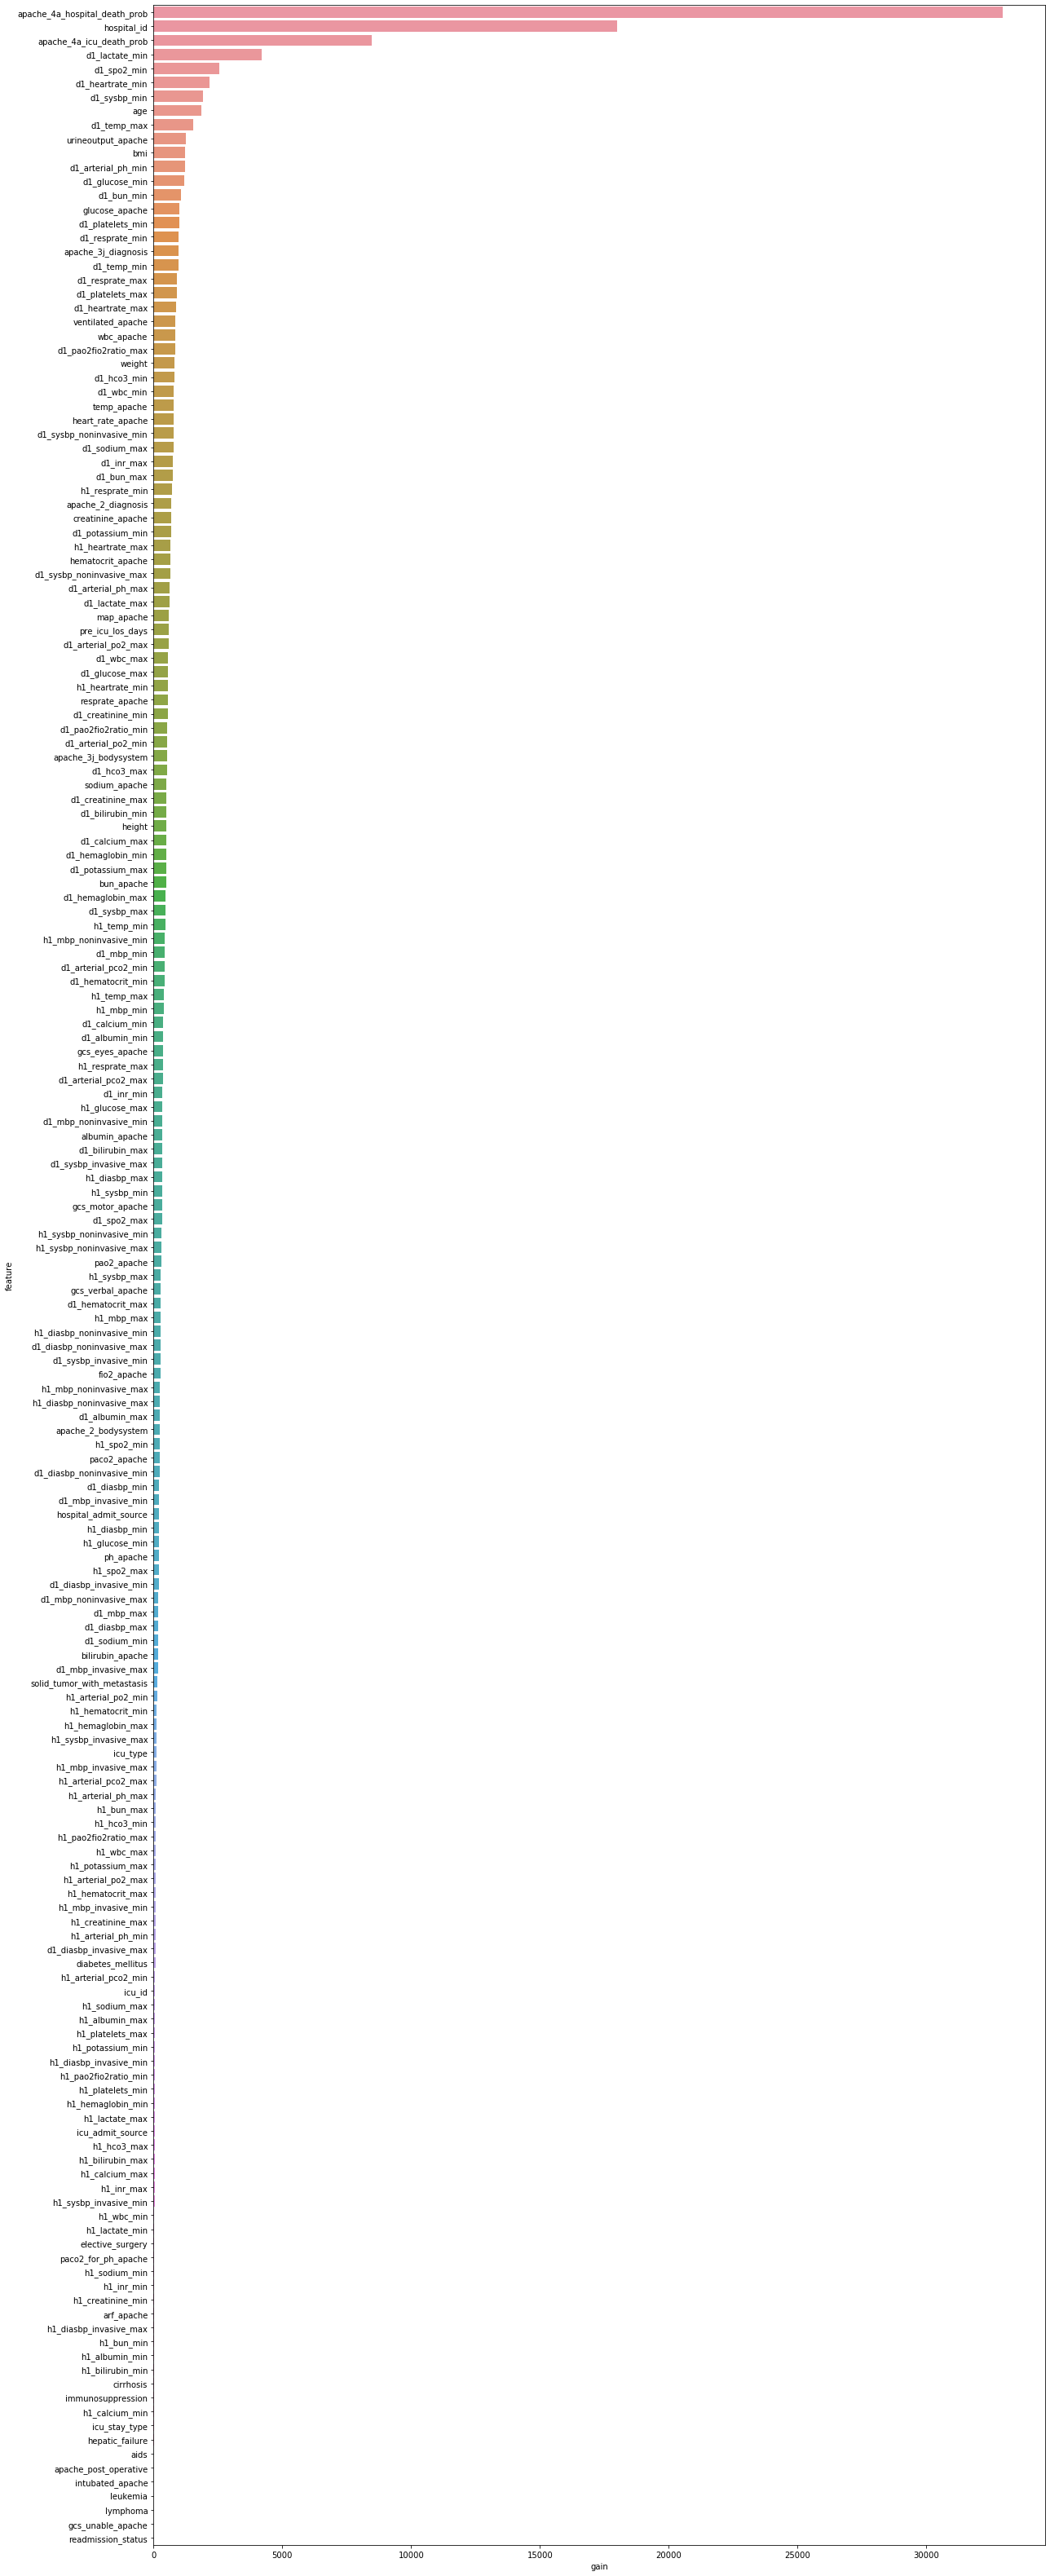

In [16]:
plot_importances(imp_df)

# Feature Importance by permutation importance algo

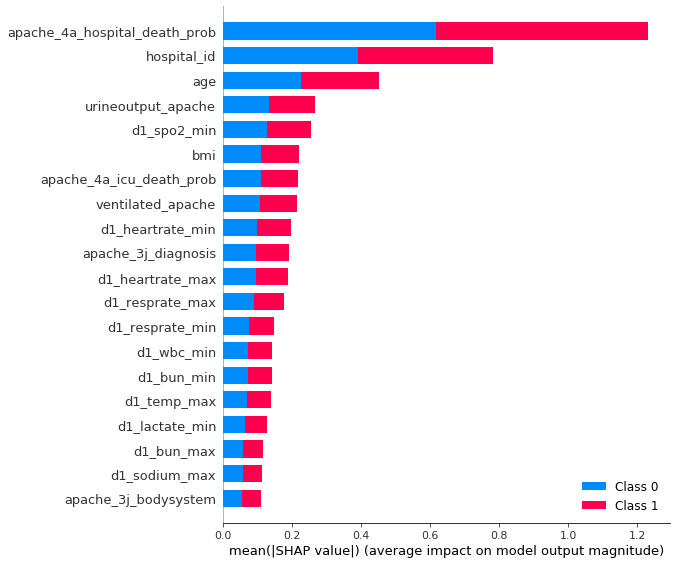

In [17]:
import shap
explainer   =  shap.TreeExplainer(lgb_model.model)
shap_values = explainer.shap_values(train[features].iloc[:1000,:])
shap.summary_plot(shap_values, train[features].iloc[:1000,:])

# Some univariate plot of the best feature

apache_4a_hospital_death_prob 0 gain : 32946.97167491913


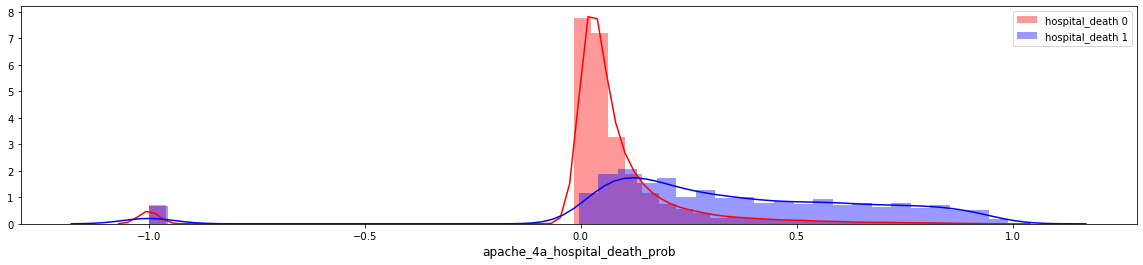

hospital_id 1 gain : 17990.860839366913


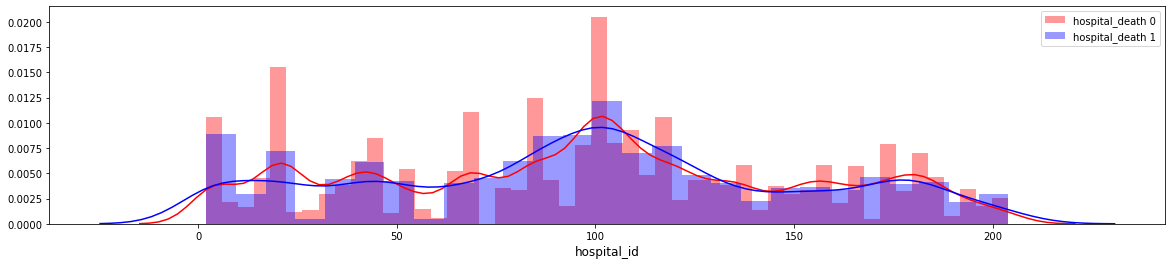

apache_4a_icu_death_prob 2 gain : 8477.814859390259


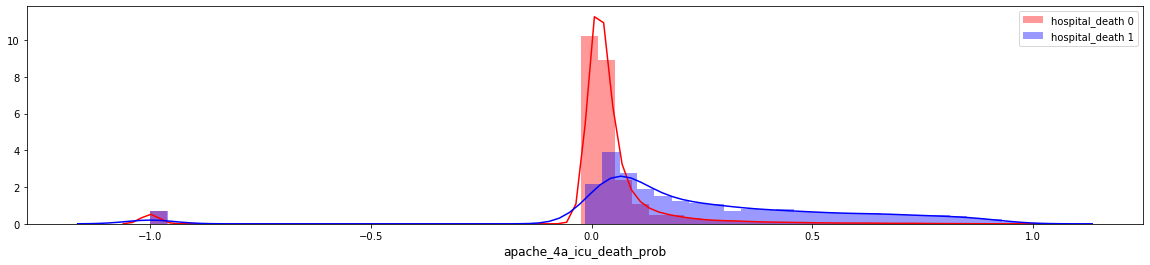

d1_lactate_min 3 gain : 4202.891261100769


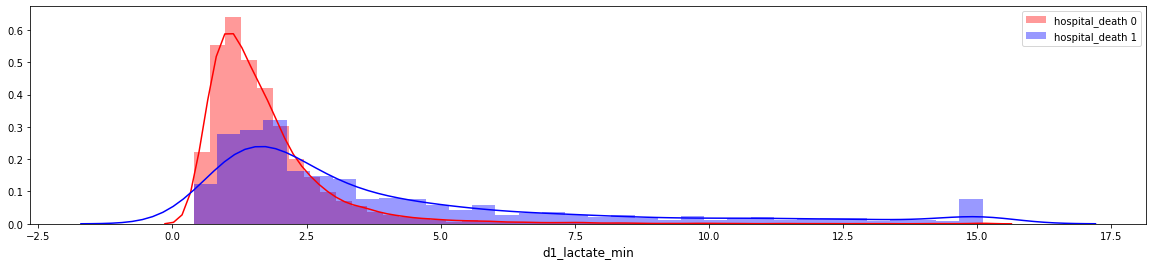

d1_spo2_min 4 gain : 2538.237645149231


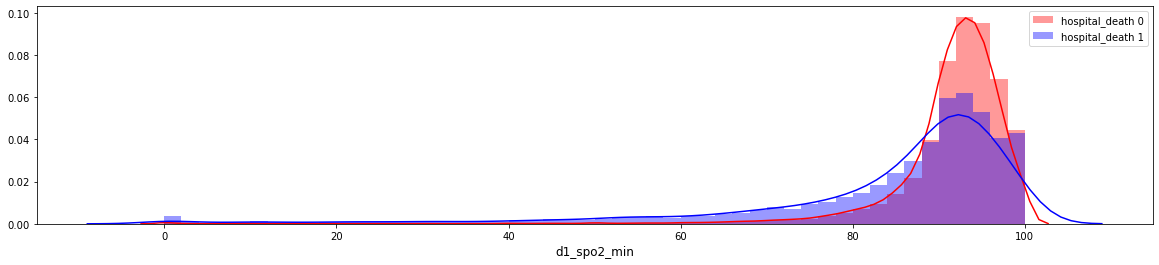

d1_heartrate_min 5 gain : 2182.87242937088


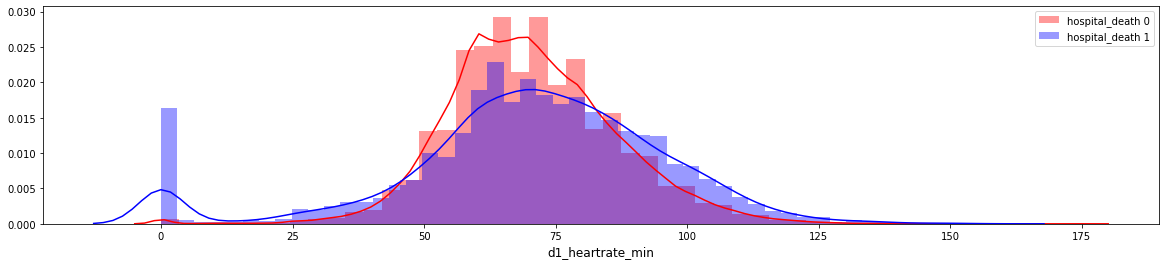

d1_sysbp_min 6 gain : 1931.6510767936707


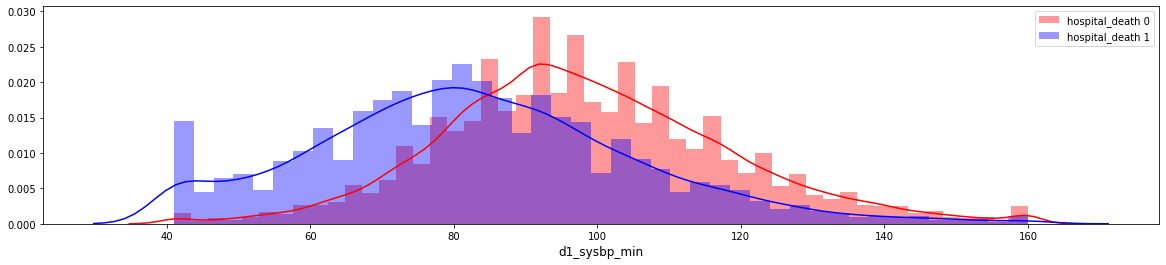

age 7 gain : 1858.254560470581


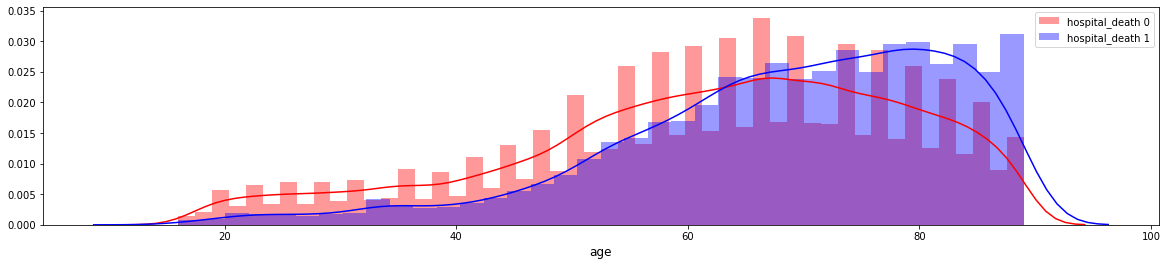

d1_temp_max 8 gain : 1548.0357689857483


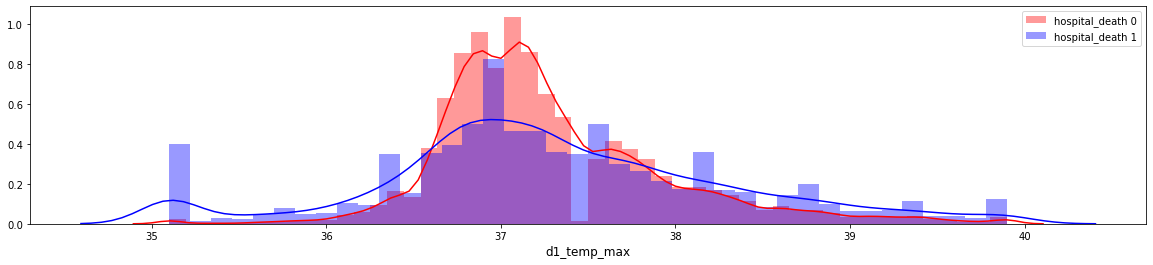

urineoutput_apache 9 gain : 1245.6402854919434


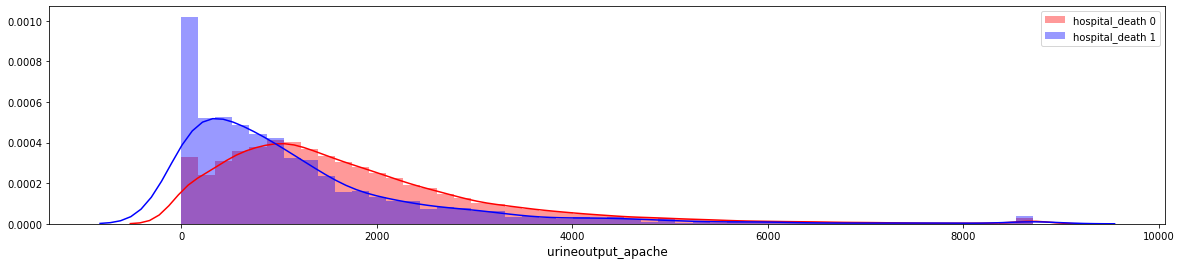

bmi 10 gain : 1222.511221408844


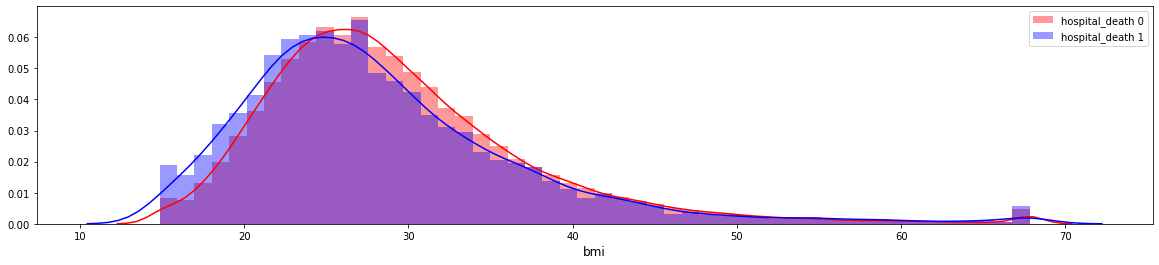

d1_arterial_ph_min 11 gain : 1220.2909626960754


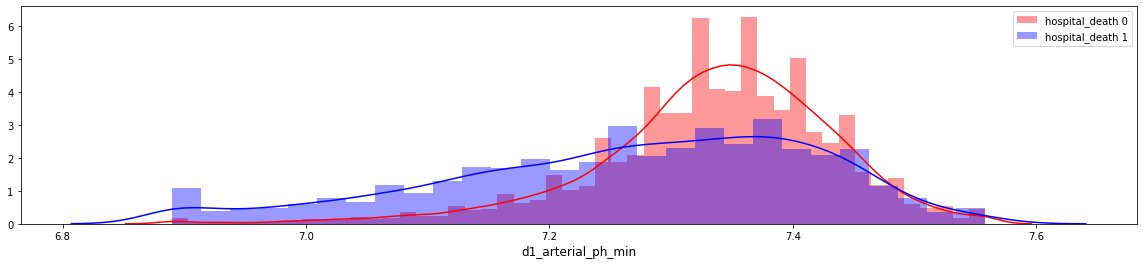

d1_glucose_min 12 gain : 1198.6917333602905


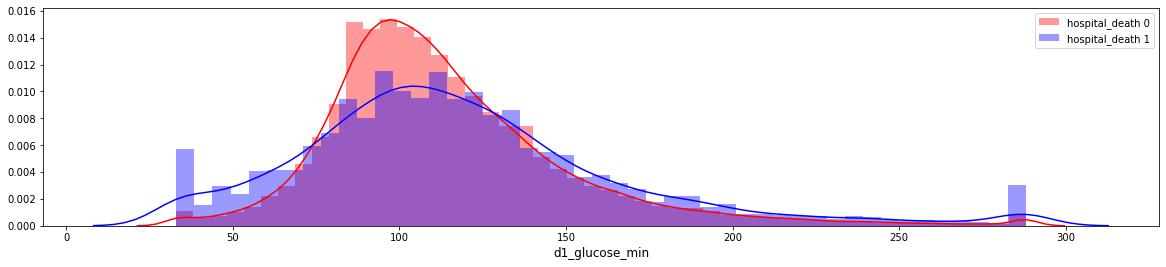

d1_bun_min 13 gain : 1074.0009651184082


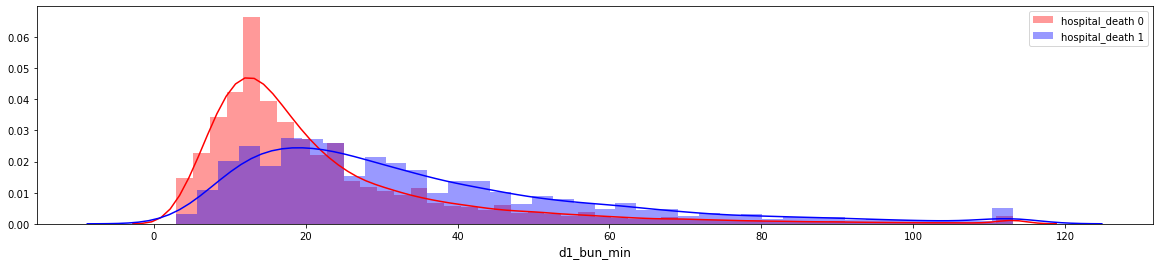

glucose_apache 14 gain : 1013.6574501991272


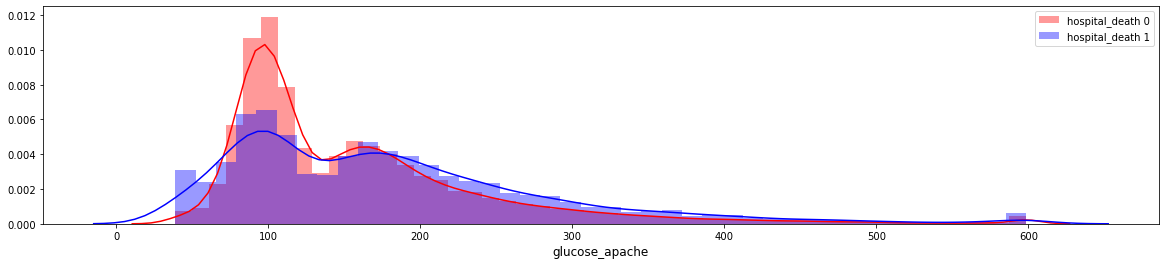

d1_platelets_min 15 gain : 1013.4152159690857


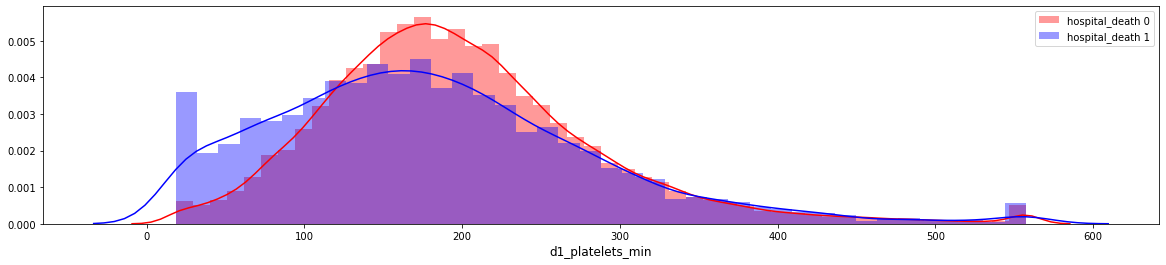

d1_resprate_min 16 gain : 982.6557683944702


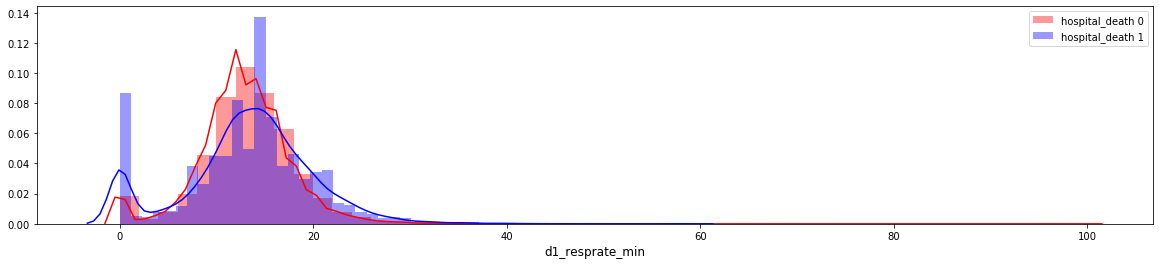

apache_3j_diagnosis 17 gain : 976.9047820568085


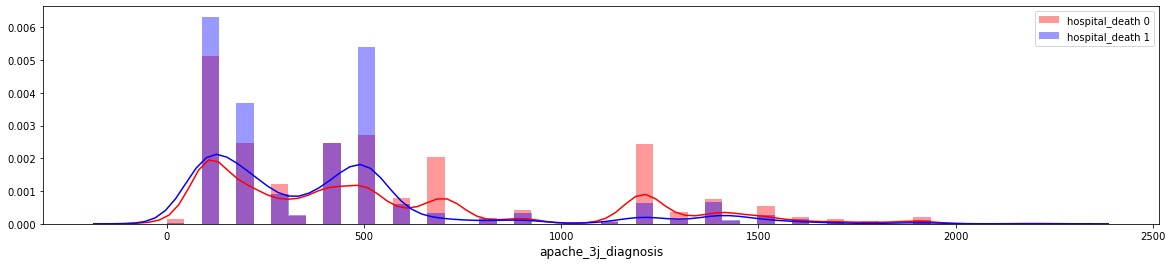

d1_temp_min 18 gain : 971.8586688041687


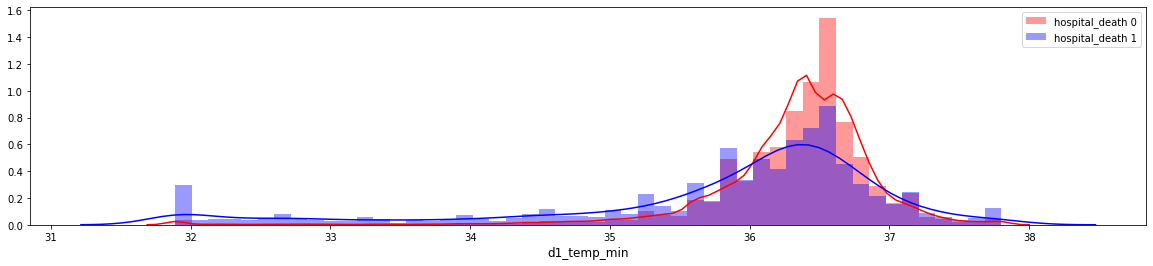

d1_resprate_max 19 gain : 920.3998045921326


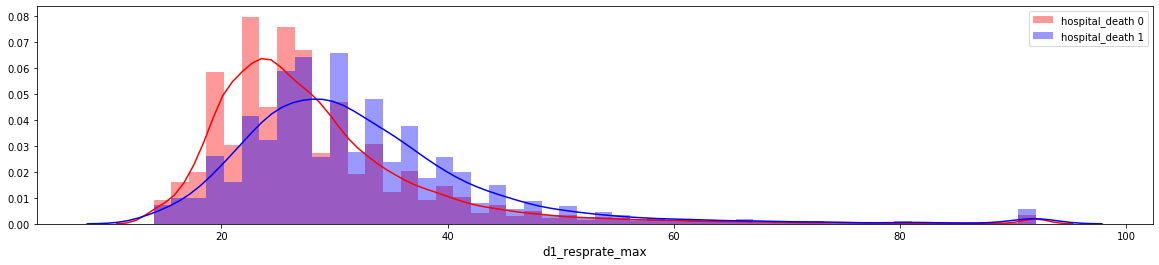

d1_platelets_max 20 gain : 904.5254201889038


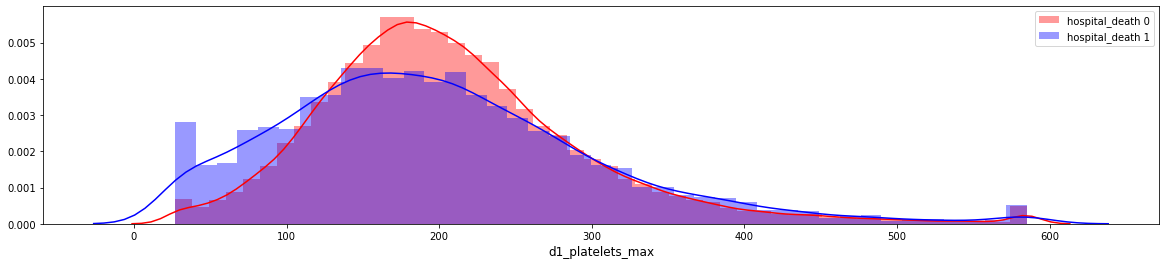

d1_heartrate_max 21 gain : 866.2697138786316


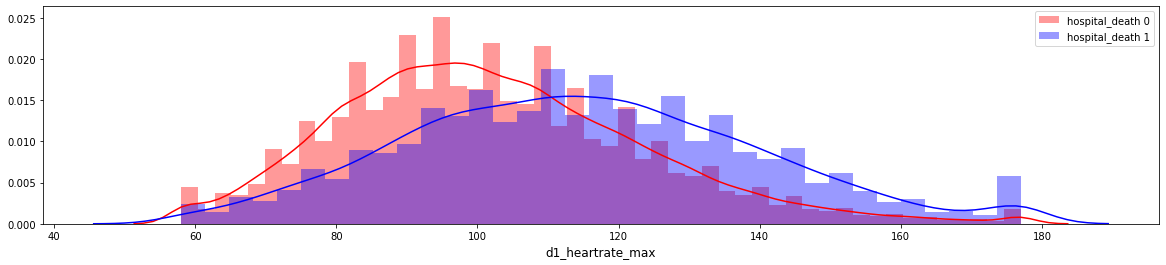

ventilated_apache 22 gain : 844.2735567092896


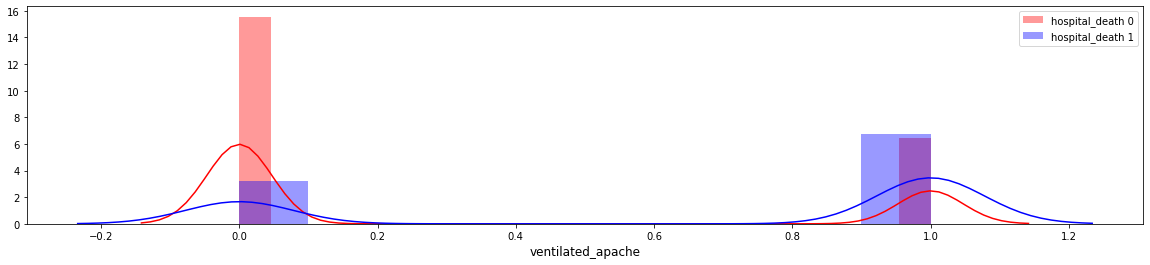

wbc_apache 23 gain : 840.6913766860962


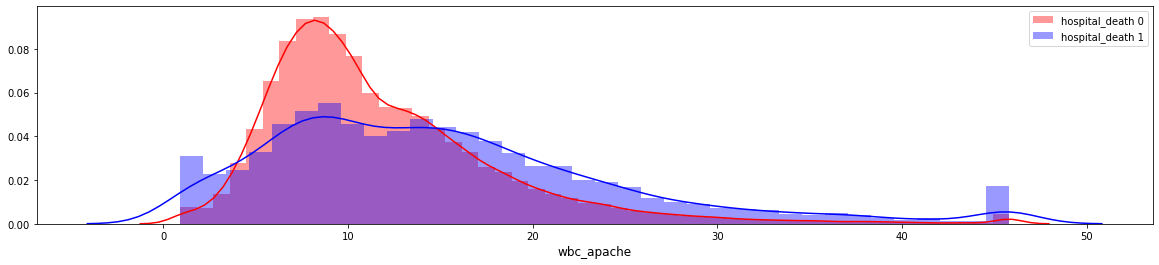

d1_pao2fio2ratio_max 24 gain : 835.2414441108704


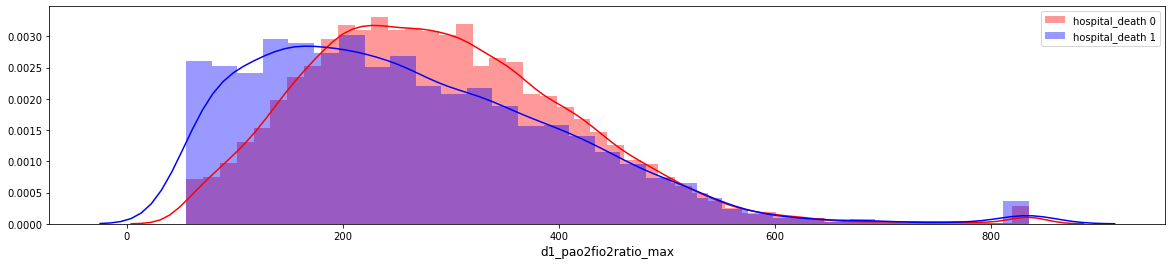

weight 25 gain : 828.0148730278015


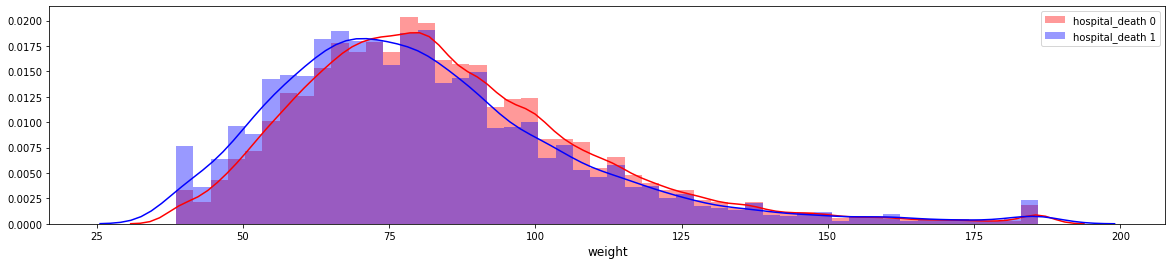

d1_hco3_min 26 gain : 826.9068946838379


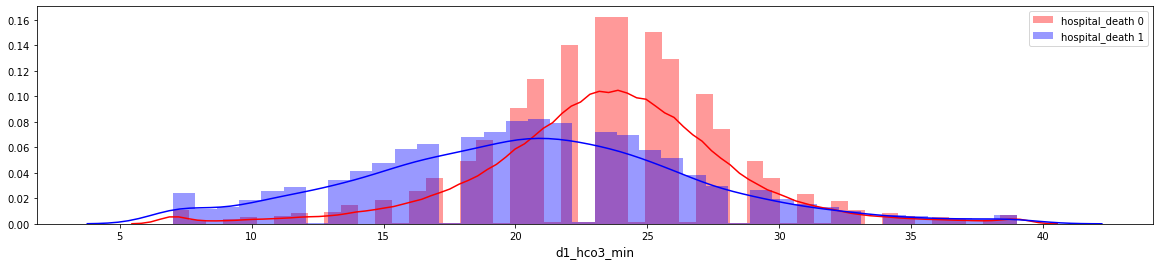

d1_wbc_min 27 gain : 787.0791456699371


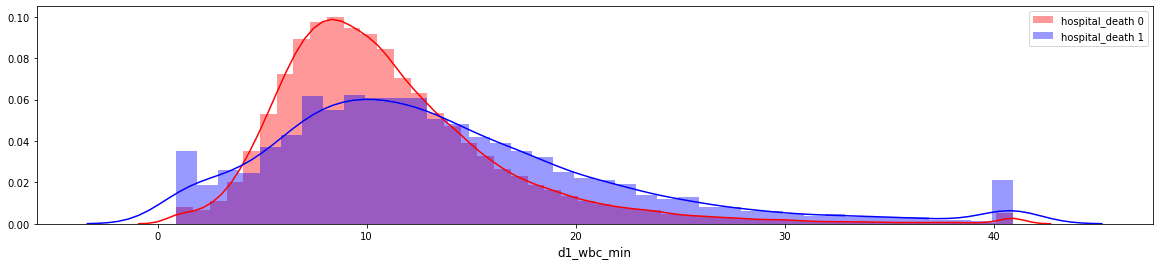

temp_apache 28 gain : 781.7299091815948


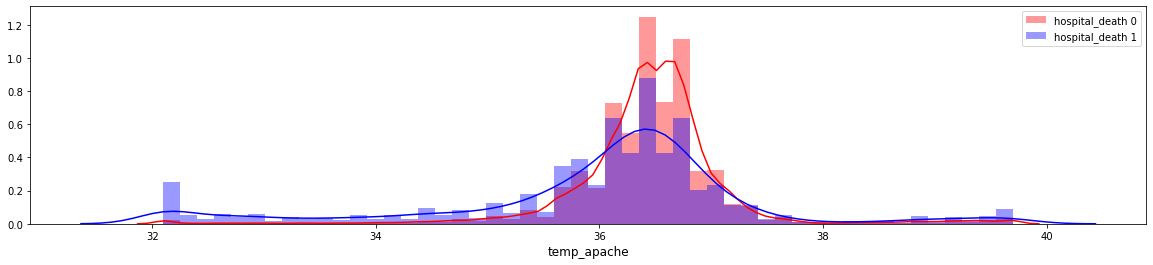

heart_rate_apache 29 gain : 780.5374217033386


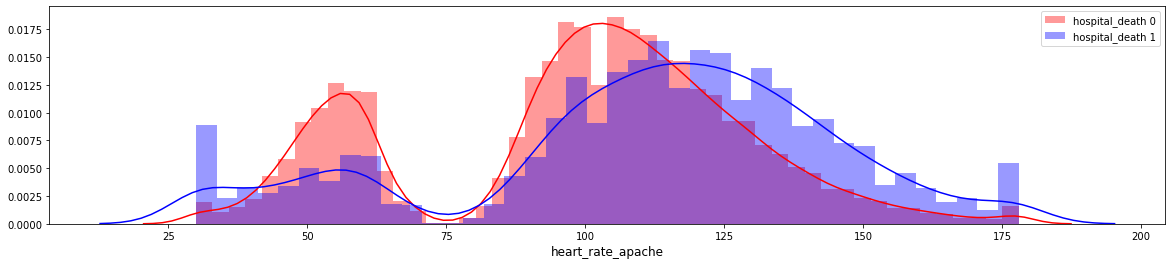

d1_sysbp_noninvasive_min 30 gain : 773.2675695419312


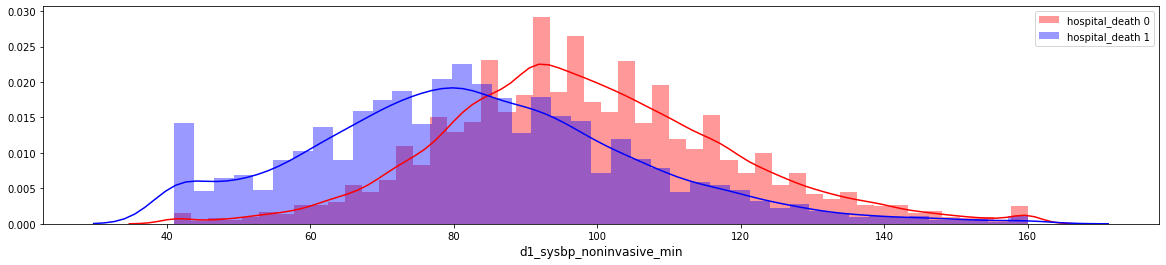

d1_sodium_max 31 gain : 770.0399618148804


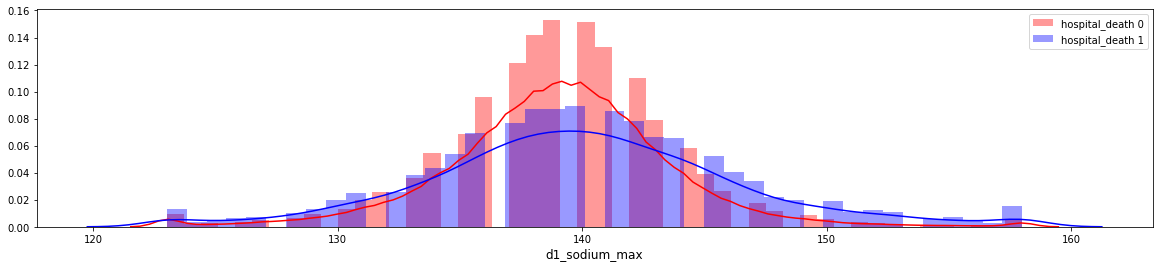

d1_inr_max 32 gain : 759.3220205307007


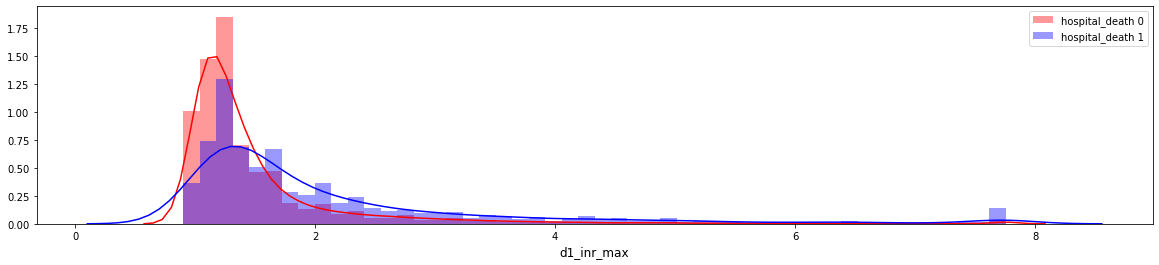

d1_bun_max 33 gain : 756.5567674636841


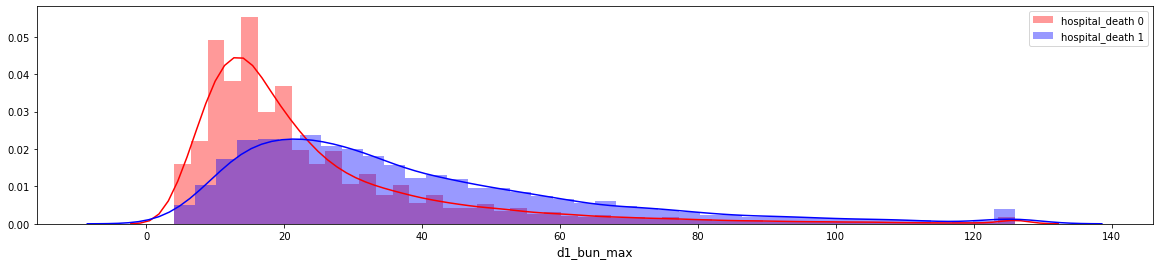

h1_resprate_min 34 gain : 726.7706203460693


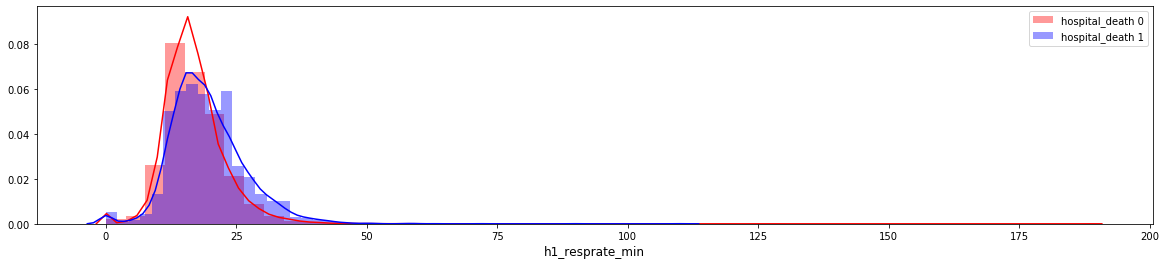

apache_2_diagnosis 35 gain : 701.0552372932434


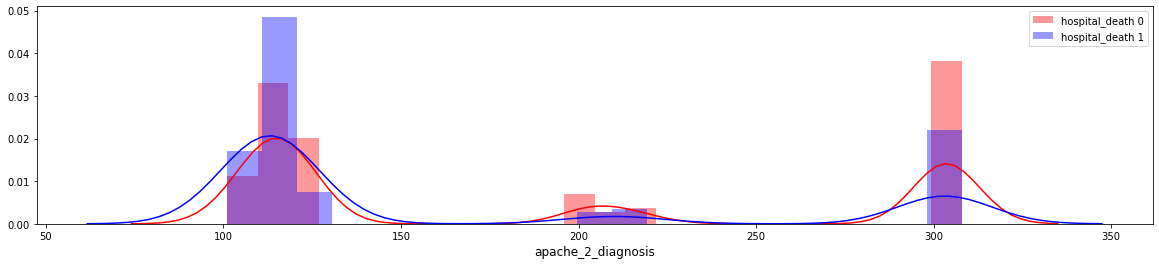

creatinine_apache 36 gain : 697.3700618743896


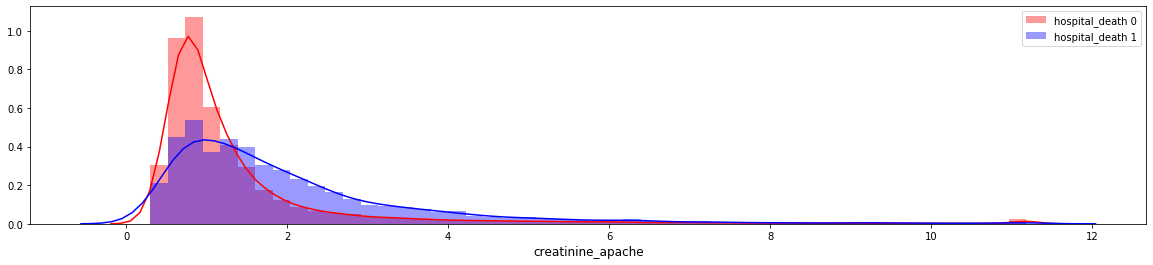

d1_potassium_min 37 gain : 679.03080701828


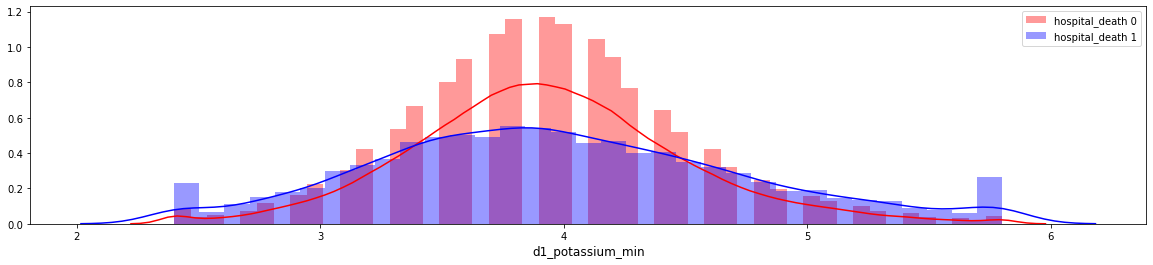

h1_heartrate_max 38 gain : 666.8125200271606


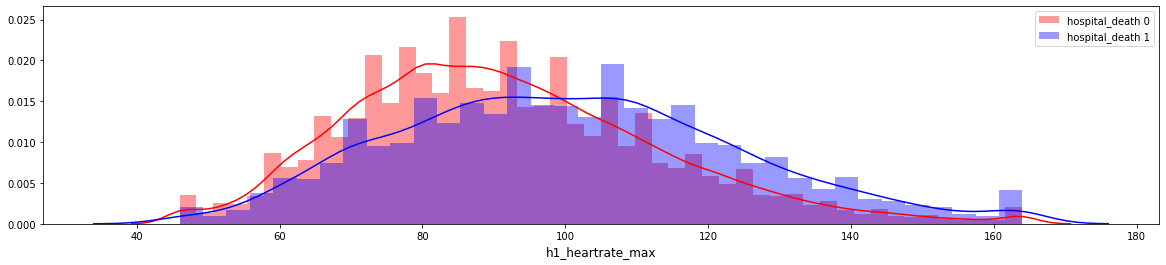

hematocrit_apache 39 gain : 661.4669909477234


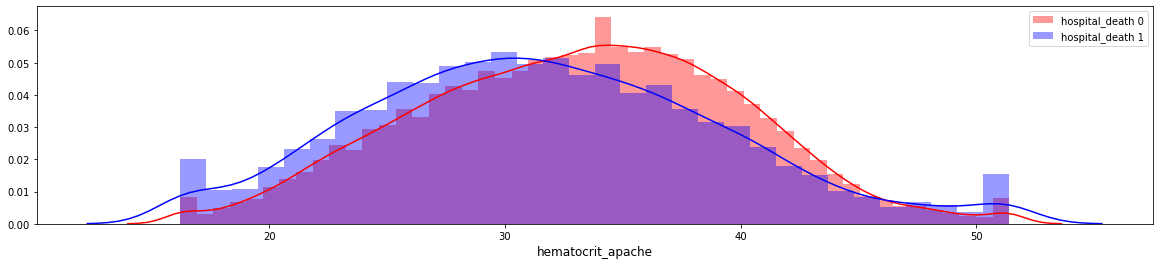

d1_sysbp_noninvasive_max 40 gain : 659.5181703567505


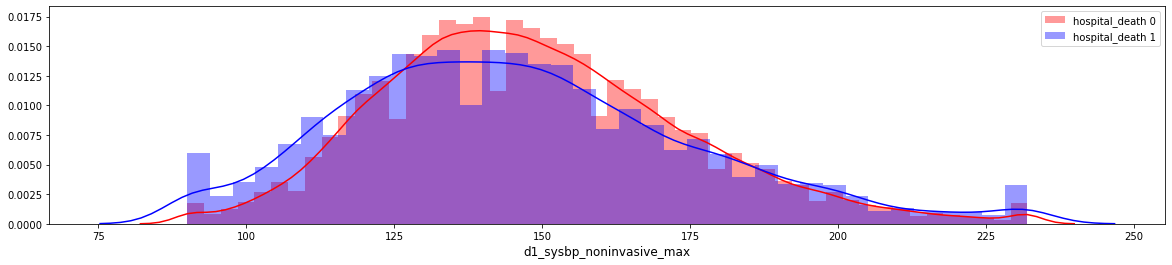

d1_arterial_ph_max 41 gain : 621.3119459152222


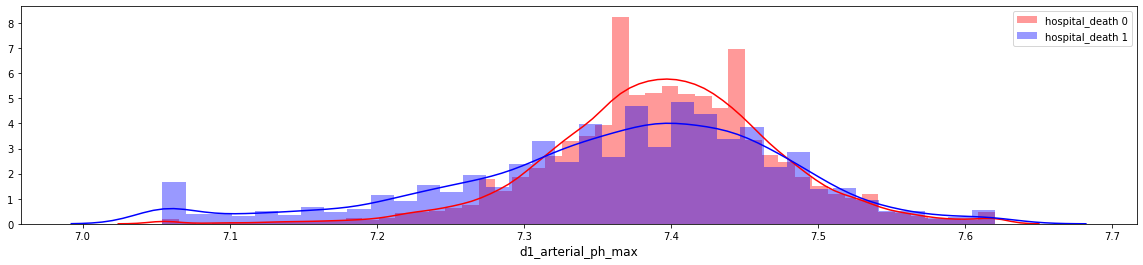

d1_lactate_max 42 gain : 614.4499292373657


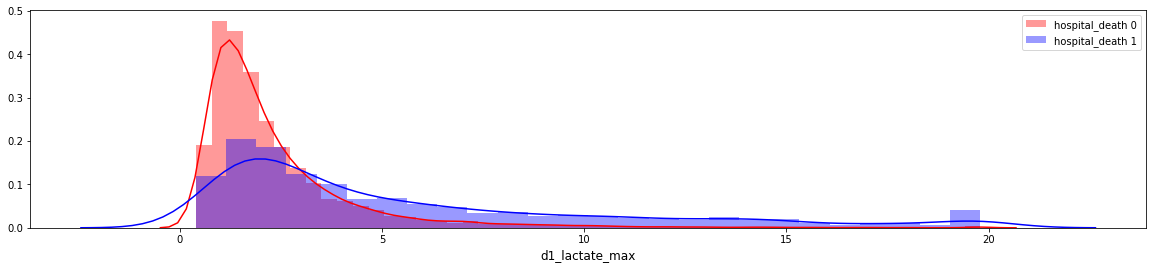

map_apache 43 gain : 604.6055846214294


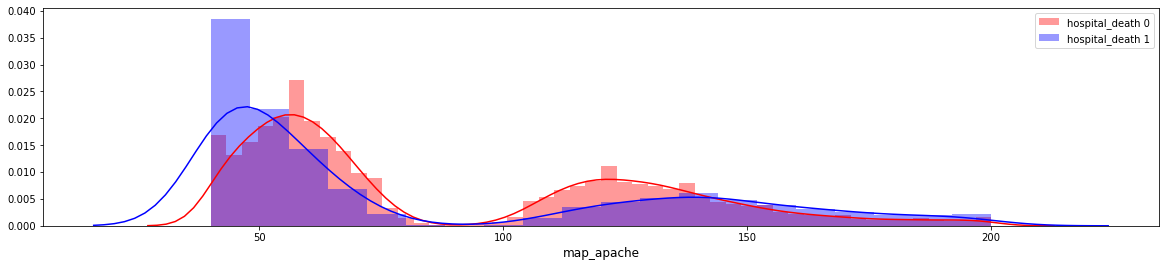

pre_icu_los_days 44 gain : 594.0882787704468


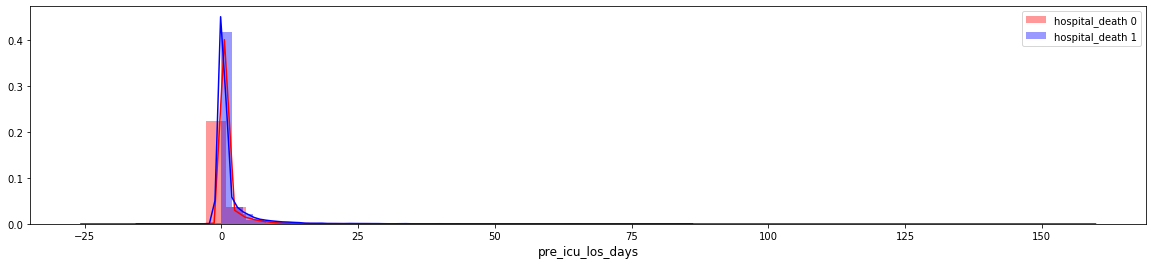

d1_arterial_po2_max 45 gain : 584.0031175613403


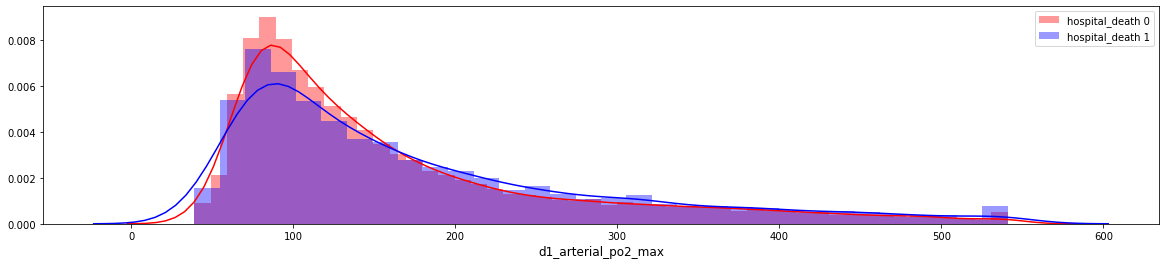

d1_wbc_max 46 gain : 572.1762208938599


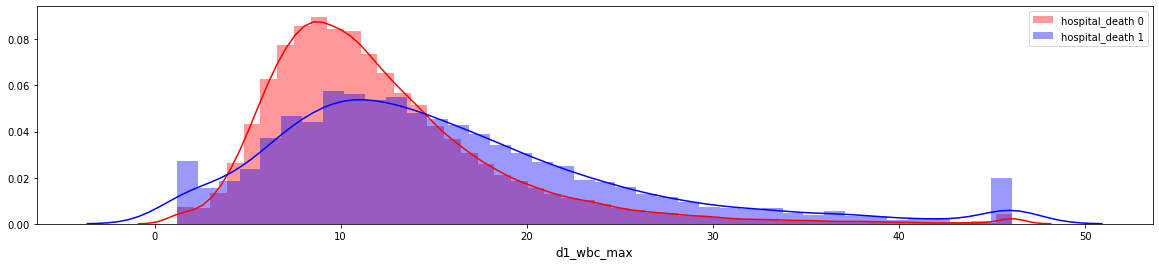

d1_glucose_max 47 gain : 554.9029793739319


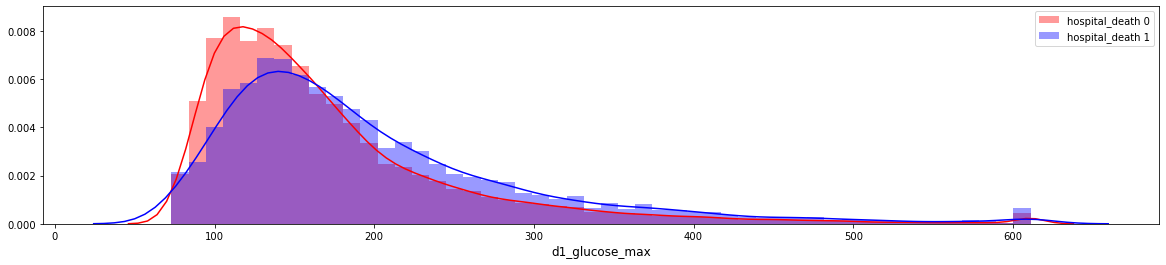

h1_heartrate_min 48 gain : 554.4324913024902


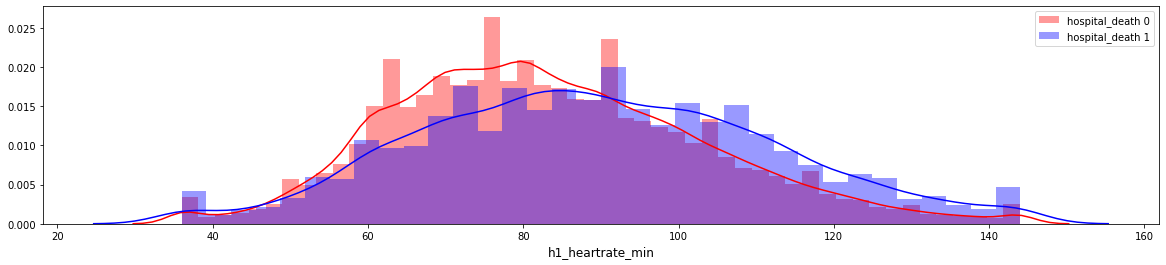

resprate_apache 49 gain : 553.100757598877


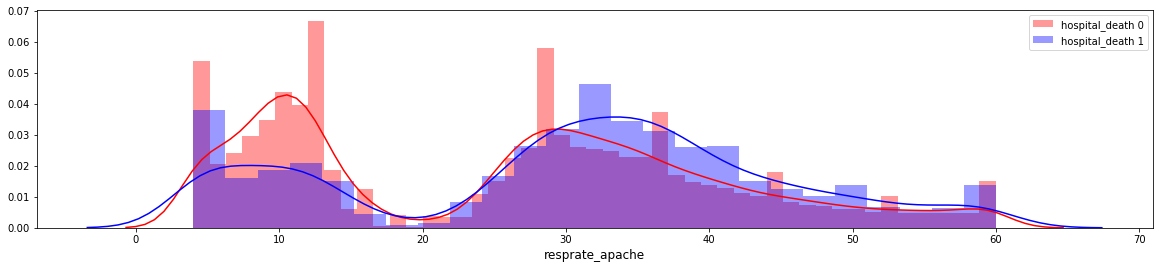

In [18]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=UserWarning)
i=0
for index, row in imp_df.sort_values(by=['gain'],ascending=False).iterrows():  
    column=row['feature']
    if i< 50:
            print(column,i,"gain :",row['gain'])
            df1      = train.loc[train['hospital_death']==0]
            df2      = train.loc[train['hospital_death']==1]

            fig = plt.figure(figsize=(20,4))
            sns.distplot(df1[column].dropna(),  color='red', label='hospital_death 0', kde=True); 
            sns.distplot(df2[column].dropna(),  color='blue', label='hospital_death 1', kde=True); 
            fig=plt.legend(loc='best')
            plt.xlabel(column, fontsize=12);
            plt.show()
            i=i+1


In [19]:
test["hospital_death"] = lgb_model.y_pred
test[["encounter_id","hospital_death"]].to_csv("submission1.csv",index=False)